In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
adata= sc.read_10x_mtx("/Users/shinjinichakraborty/desktop/filtered_feature_bc_matrix")
adata #check adata at this stage
adata.obs #gives list of cells. It is a pandas dataframe
adata.var #gives list of genes. It is a pandas dataframe
adata.X   #sparse matrix combining cell and gene data

#adding columns to the object
adata.obs["cell_label"]="cell_xx"
adata.obs #checking if new column is added to the object

#next step is quality control.This will include filtering out low reads in cells and similar noise! 
#This is different from what cell-ranger does.
#low gene expression, less cells with particular gene expressed and mitochondrial gene

#cells with low gene expression - preprocessing -pp

sc.pp.filter_cells(adata,min_genes=50)
adata #check if adata has filtered genes excluded

#filter low gene expression - preprocessing -pp

sc.pp.filter_genes(adata,min_cells=3)
adata #check if adata has filtered cells excluded

#filter mitochondrial content. This will give you a boolean array
adata.var["mt"]=adata.var_names.str.startswith("MT-")

#filter mitochondrial content
adata.obs['percent_mito'] = np.sum(adata[:, adata.var['mt'].values].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs #to check if 'percent mito' is added to the object dataframe

,cell_label,n_genes,percent_mito
AAACCCAAGGAGAGTA-1,cell_xx,2620,0.107772
AAACGCTTCAGCCCAG-1,cell_xx,1808,0.079688
AAAGAACAGACGACTG-1,cell_xx,1562,0.061916
AAAGAACCAATGGCAG-1,cell_xx,1225,0.059913
AAAGAACGTCTGCAAT-1,cell_xx,1831,0.066171
...,...,...,...
TTTCCTCTCTCTTGCG-1,cell_xx,3106,0.114413
TTTGATCTCTTTGGAG-1,cell_xx,1893,0.088340
TTTGGTTAGTAACCTC-1,cell_xx,1352,0.085523
TTTGGTTGTAGAATAC-1,cell_xx,2818,0.117273


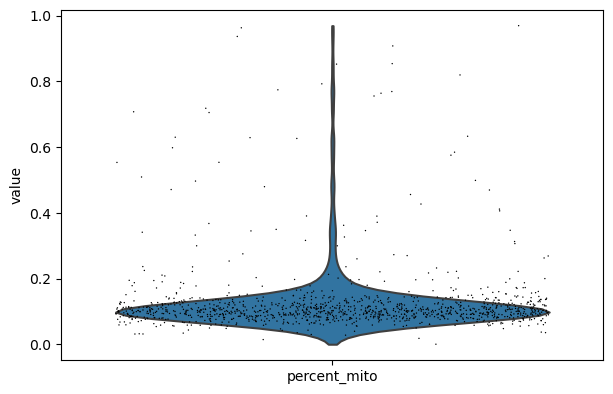

/Users/shinjinichakraborty/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


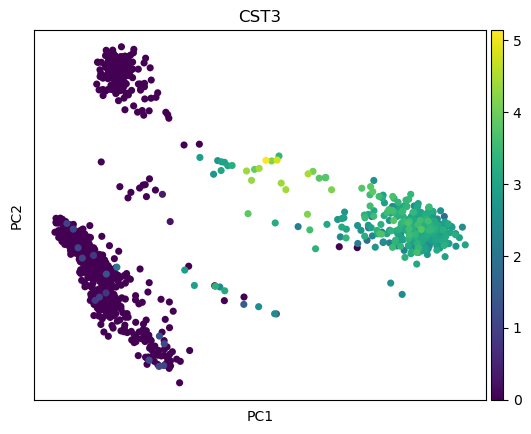

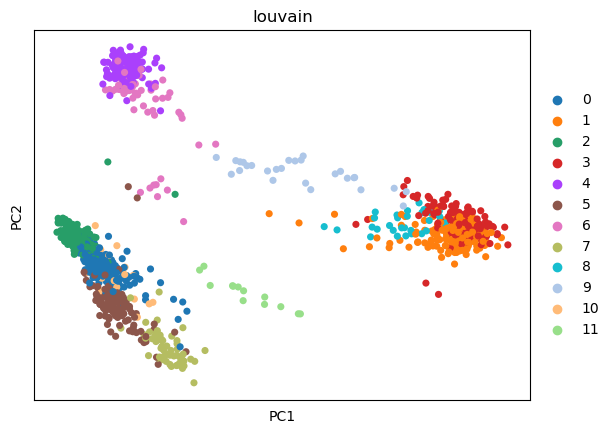

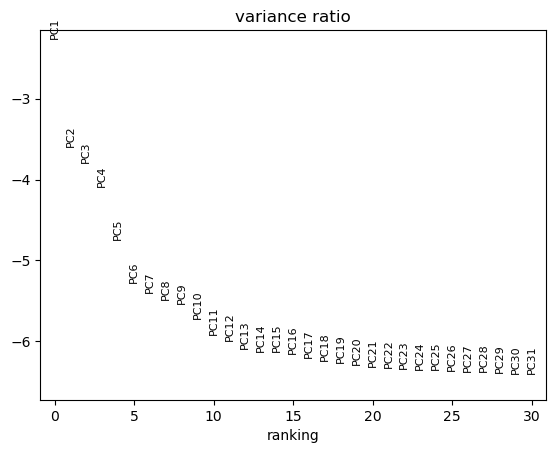

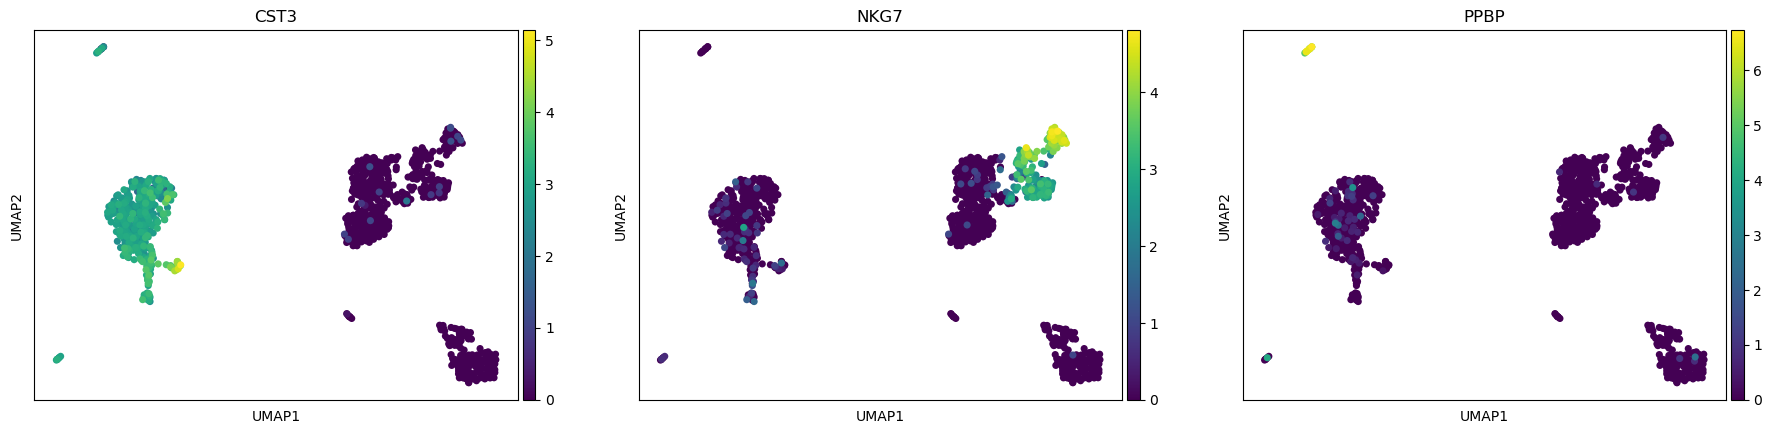

In [4]:

sc.pl.violin(adata, 'percent_mito', jitter=0.4) #gives violin plot, giving an idea what threshold can be suitably set
adata = adata[adata.obs['percent_mito'] < 0.3, :] #this is called boolean filtering
adata #check if adata has filtered mitochondrial genes

# Normalization has two steps - preprocessing normalization and log transformation

sc.pp.normalize_total(adata, target_sum=1e4) #normalization
sc.pp.log1p(adata) #log transformation
adata #Anndata object number remains the same, but an additional layer is added when log transformed

# Downstream analysis starts with dimensionality reduction. First step is PCA
# And then, PCA output used as the input for tSNE and UMAP

sc.tl.pca(adata, svd_solver='arpack')

adata #several other layers added

sc.pl.pca(adata, color='CST3')

#Now we perform UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # this computes neighborhood graph required for UMAP
sc.tl.umap(adata)
# Run Louvain clustering
sc.tl.louvain(adata)
# Plot PCA colored by Louvain clusters
sc.pl.pca(adata, color='louvain')

# We can plot gene specific UMAPs as well 

sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])



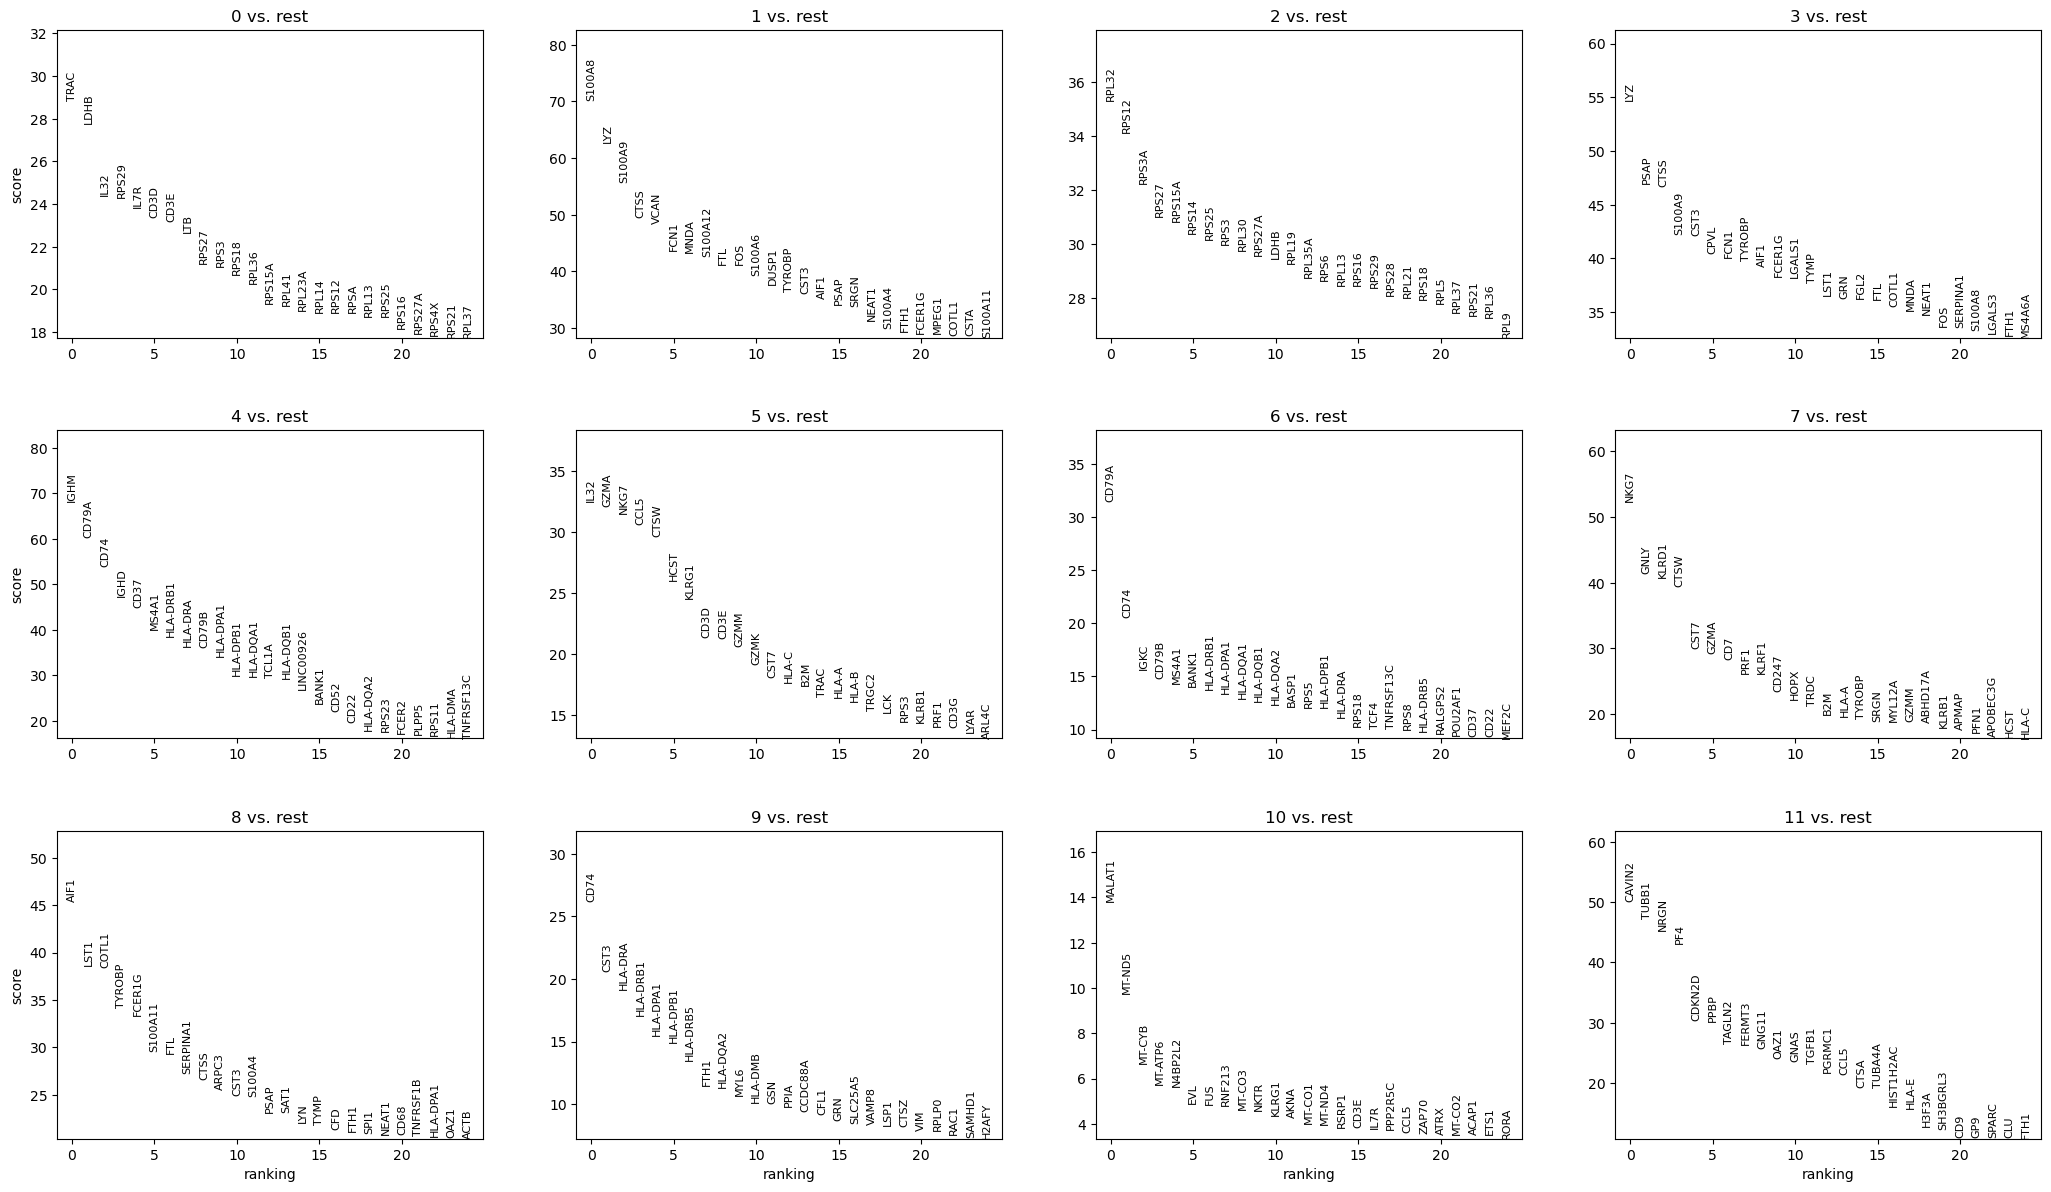

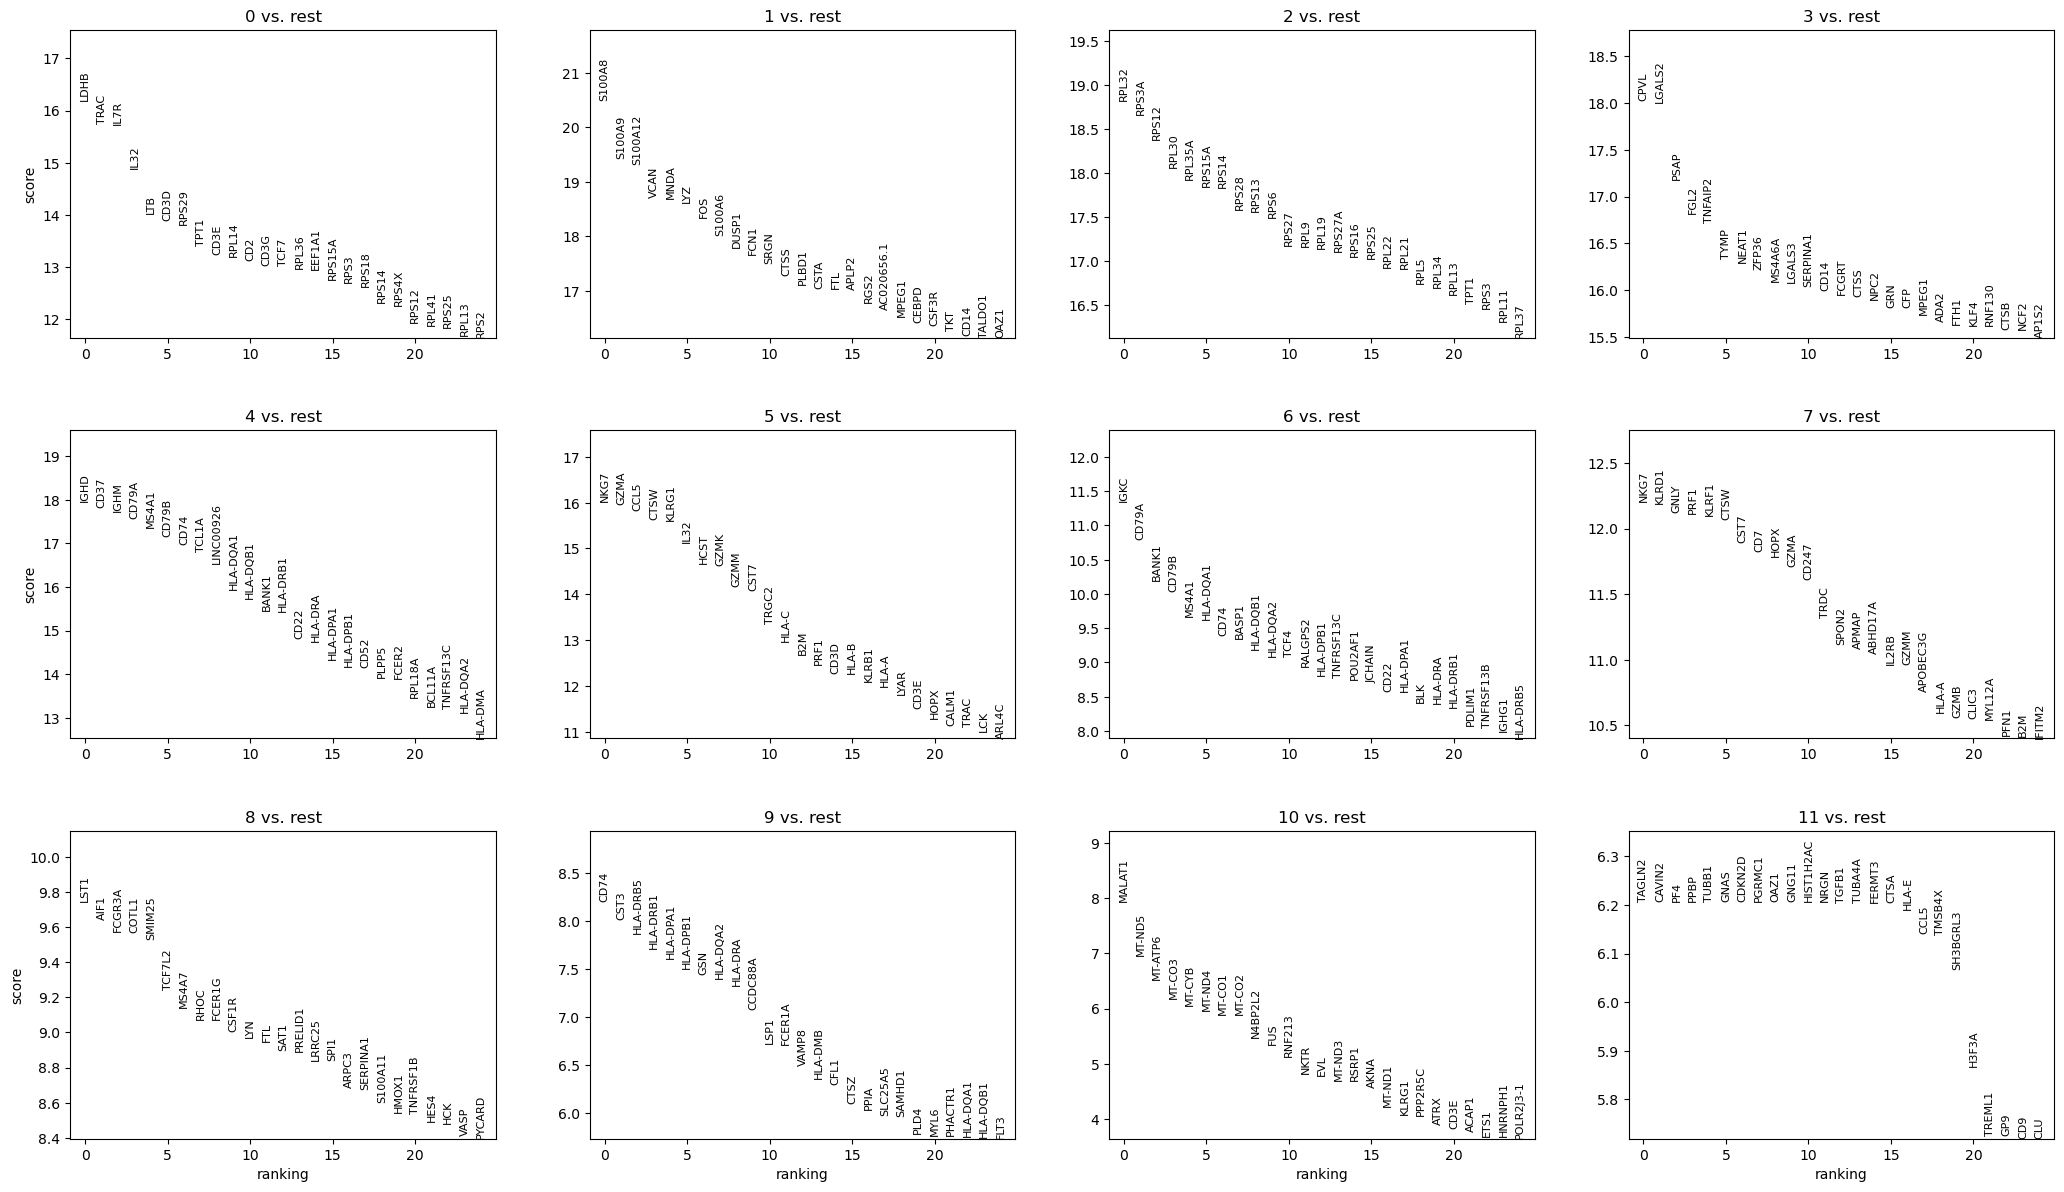

/Users/shinjinichakraborty/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


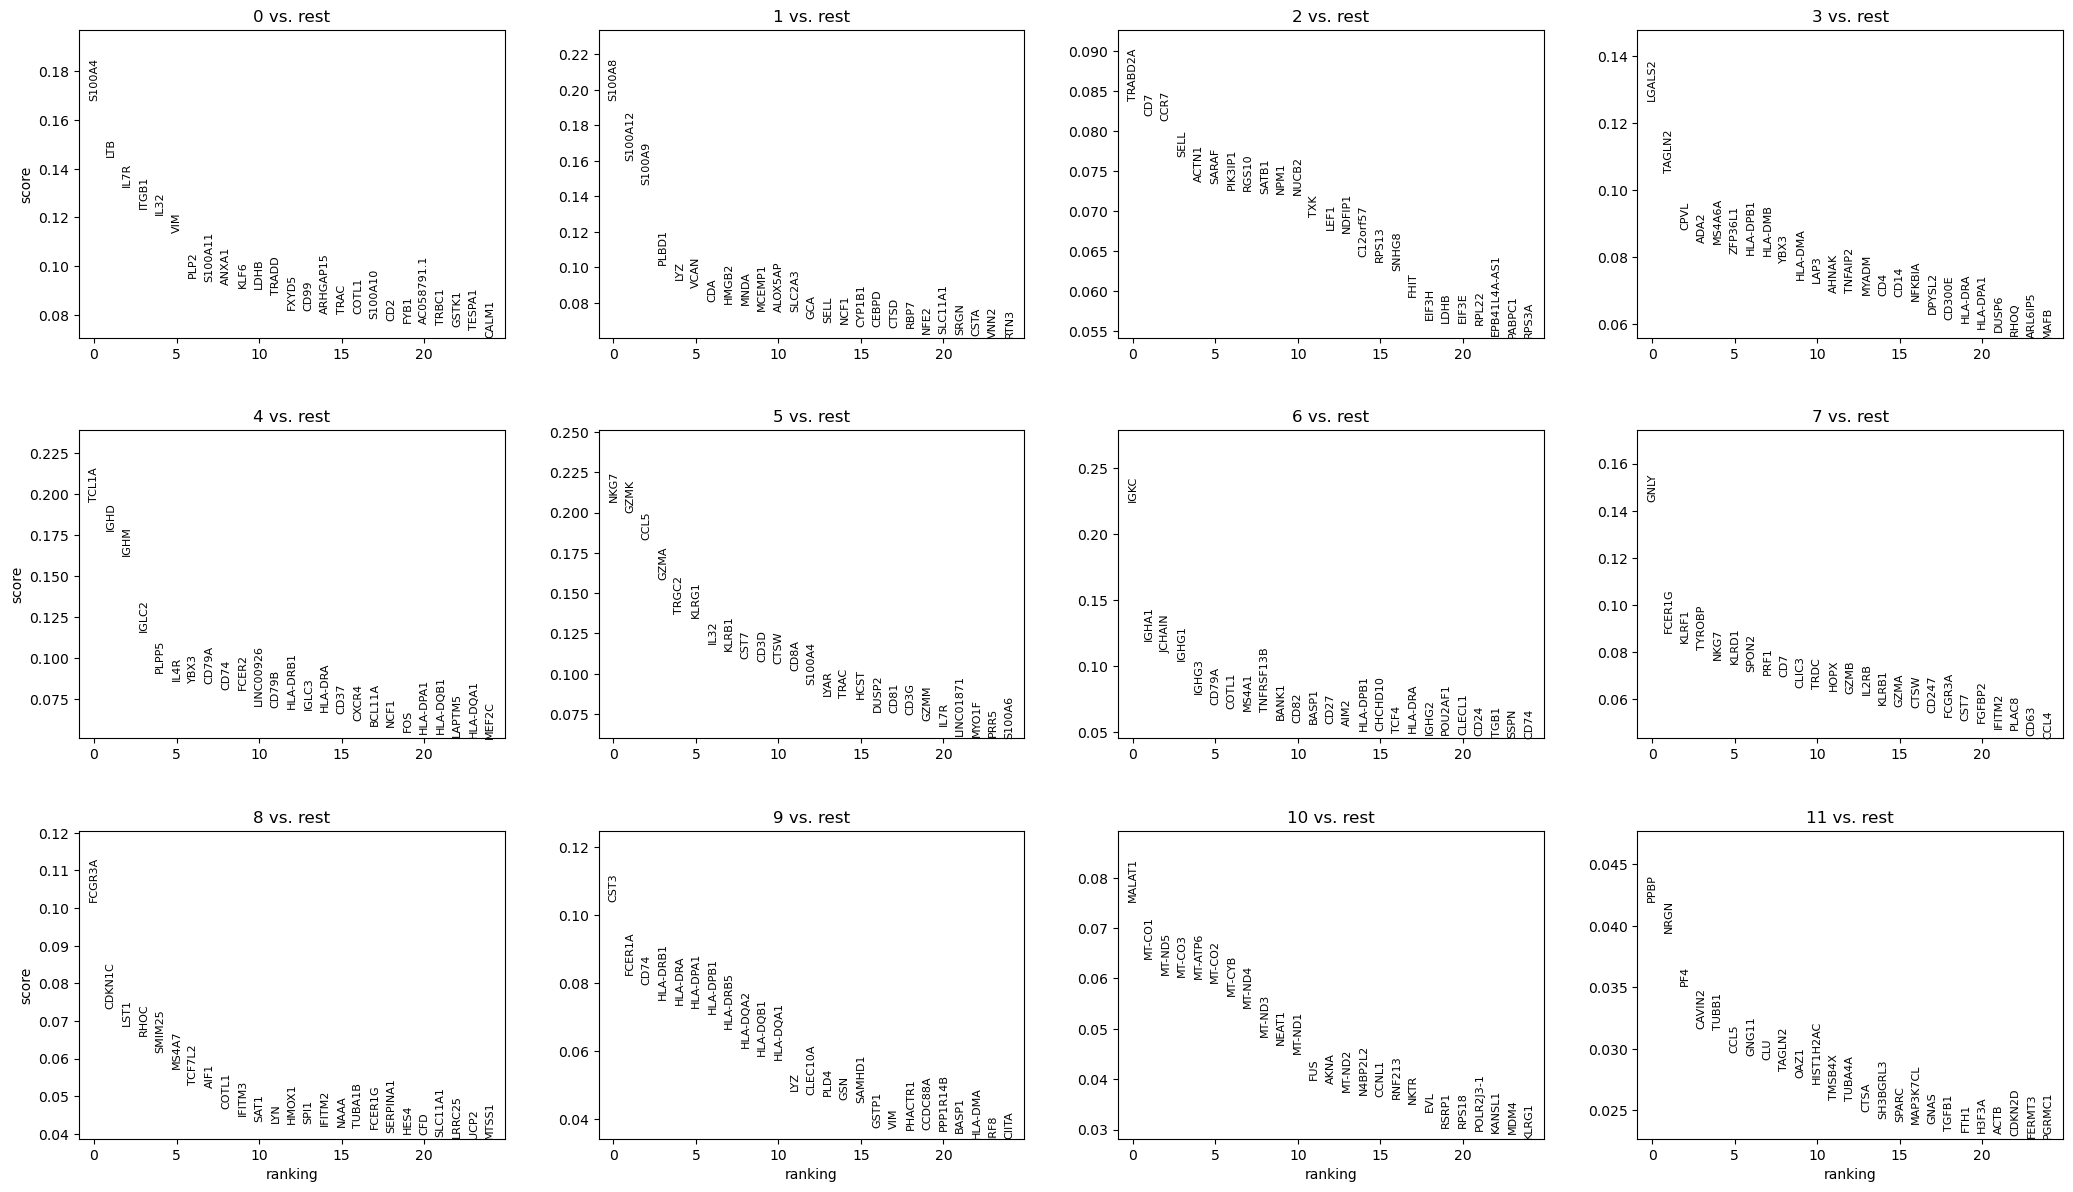

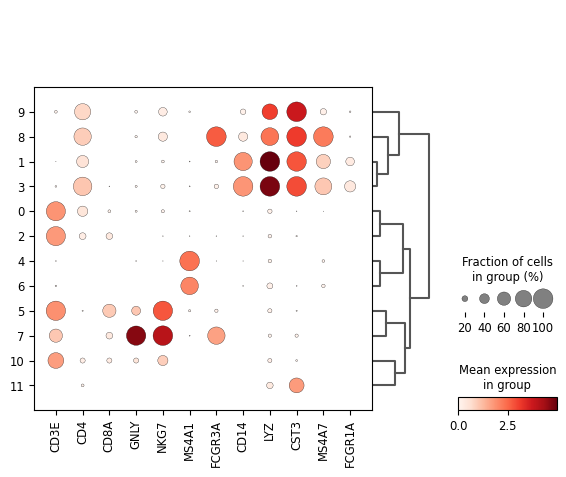

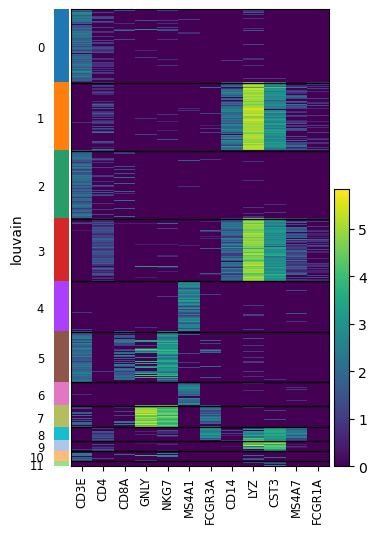

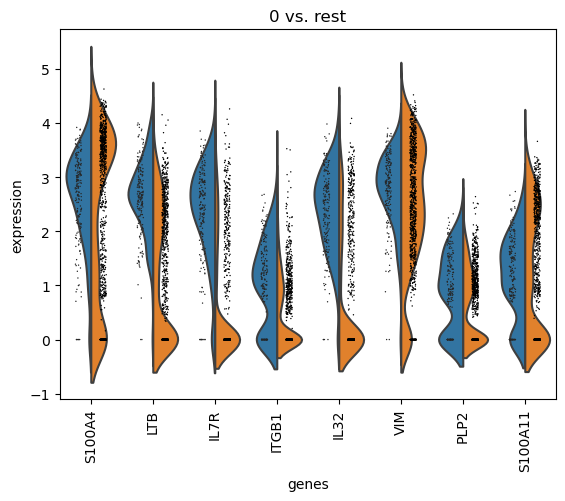

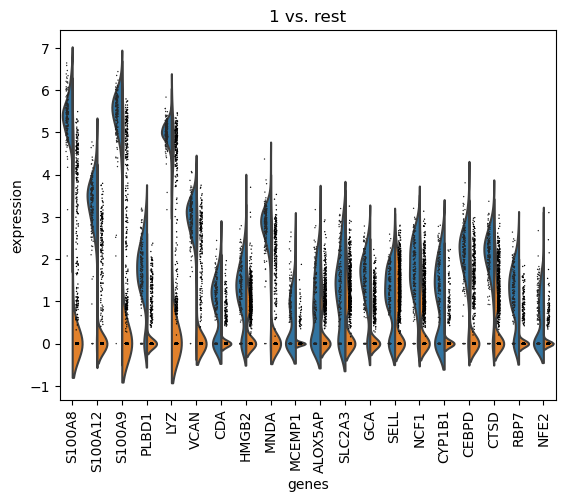

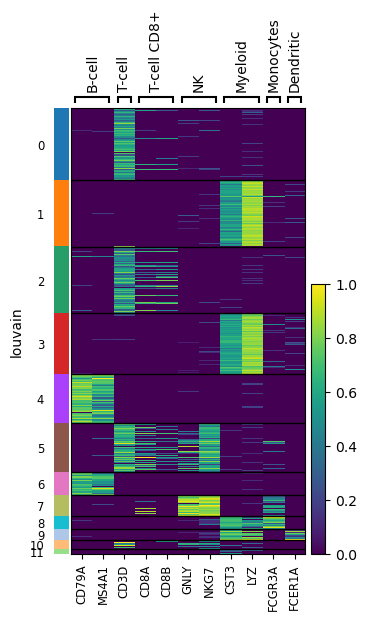

In [5]:
#compute a ranking for the highly differential genes in each cluster

sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Mann-Whitney Test can also be used 
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# logistic regression can also be used 

sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(7) #the argument for head can be changed ot include more genes

# plotting a dendrogram for specific genes

genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","FCGR3A","CD14","LYZ","CST3","MS4A7","FCGR1A"]
sc.pl.dotplot(adata, genes, groupby='louvain', dendrogram=True)
sc.pl.heatmap(adata, genes, groupby='louvain')

# Violin plot

sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=20)

# use marker genes as dictionary to group them
marker_genes_dict = {'B-cell': ['CD79A', 'MS4A1'],
                     'T-cell': 'CD3D',
                     'T-cell CD8+': ['CD8A', 'CD8B'],
                     'NK': ['GNLY', 'NKG7'],
                     'Myeloid': ['CST3', 'LYZ'],
                     'Monocytes': ['FCGR3A'],
                     'Dendritic': ['FCER1A']}

ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='louvain', standard_scale='var')


In [ ]:
# how to identify cell types ? 
# how to identify and label cell types in louvain plot with gene expression ? Is this only pre defined? 
# Why not use leiden plot (it could identify 15 clusters instead of 11)?